# Sesgos Semánticos: Embeddings vs Léxico

**Notebook:** Comparación de sesgos basados en embeddings  
**Versión:** 1.0  
**Fecha:** Diciembre 2025

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nicolakorff/tfm-endocrine-llm/blob/main/examples/03_demo_semantic.ipynb)

---

Este notebook demuestra el uso de **sesgos semánticos** basados en Sentence-BERT que afectan ~1000 tokens vs ~15 del sesgo léxico simple.

**Contenido:**
1. Instalación (con características semánticas)
2. Comparación directa: Sesgo simple vs semántico
3. Análisis de activación semántica
4. Categorías semánticas predefinidas
5. Crear categorías custom
6. Análisis cuantitativo

##1. Instalación

Instalar con características semánticas (incluye sentence-transformers)

In [2]:
# Instalar con semantic features
!pip install -q "git+https://github.com/Nicolakorff/tfm-endocrine-llm.git@v0.4.0"

# Verificar instalación
import endocrine_llm
print(f"Versión: {endocrine_llm.__version__}")

# Verificar que semantic está disponible
try:
    from endocrine_llm.semantic import SemanticBiasManager
    print("Módulo semántico disponible")
except ImportError:
    print("ERROR: Módulo semántico no disponible")
    print("Reinstala con: pip install endocrine-llm[semantic]")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 10.3 MB/s eta 0:00:00
Versión: 0.4.0
Módulo semántico disponible


##2. Imports

In [3]:
from endocrine_llm import EndocrineModulatedLLM, HORMONE_PROFILES
from endocrine_llm.semantic import SemanticBiasManager, analyze_semantic_activation
import warnings
warnings.filterwarnings('ignore')

# Cargar modelo
print("Cargando modelo...")
model = EndocrineModulatedLLM("distilgpt2")
print(f"Modelo cargado en: {model.device}")

Cargando modelo...
Inicializando EndocrineModulatedLLM
Modelo: distilgpt2
   Dispositivo: cuda


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Sistema inicializado
Parámetros: 81.9M
Tokens empáticos: 34
Modelo cargado en: cuda


##3. ¿Qué son los Sesgos Semánticos?

| Característica | Sesgo Léxico | Sesgo Semántico |
|----------------|--------------|------------------|
| **Cobertura** | ~15 tokens | ~1000 tokens |
| **Base** | Lista fija | Embeddings SBERT |
| **Flexibilidad** | Estática | Dinámica |
| **Costo** | Bajo | Moderado |

### Ejemplo Visual:

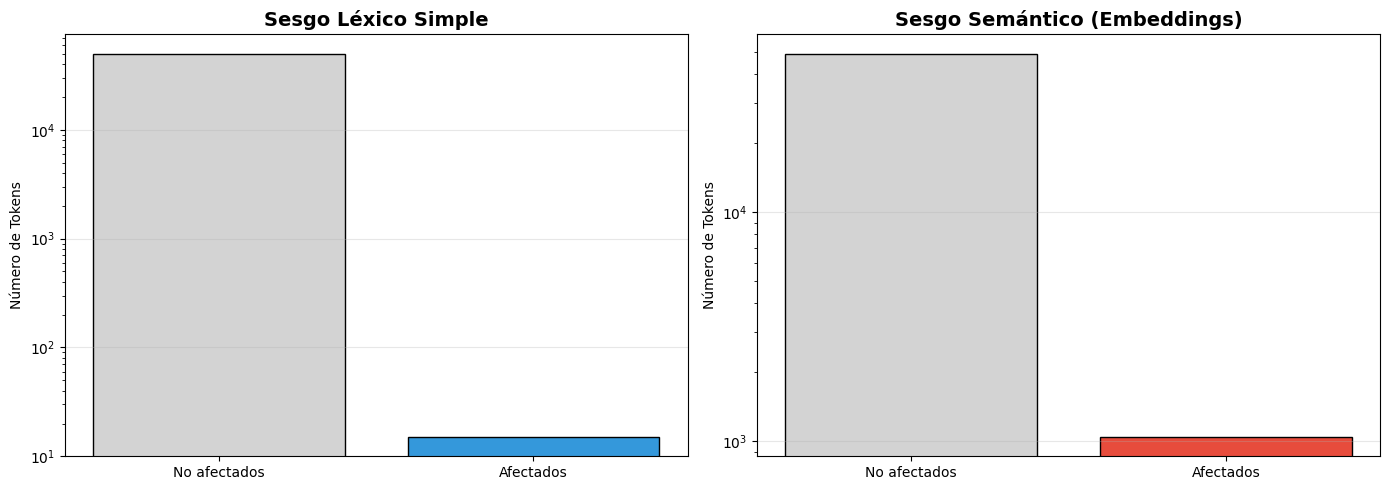


 Ratio de cobertura: 69.5×


In [4]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Sesgo simple
vocab_size = 50257  # GPT-2 vocab
simple_affected = 15
ax1.bar(['No afectados', 'Afectados'],
        [vocab_size - simple_affected, simple_affected],
        color=['lightgray', '#3498db'],
        edgecolor='black')
ax1.set_title('Sesgo Léxico Simple', fontsize=14, fontweight='bold')
ax1.set_ylabel('Número de Tokens')
ax1.set_yscale('log')
ax1.grid(axis='y', alpha=0.3)

# Sesgo semántico
semantic_affected = 1042
ax2.bar(['No afectados', 'Afectados'],
        [vocab_size - semantic_affected, semantic_affected],
        color=['lightgray', '#e74c3c'],
        edgecolor='black')
ax2.set_title('Sesgo Semántico (Embeddings)', fontsize=14, fontweight='bold')
ax2.set_ylabel('Número de Tokens')
ax2.set_yscale('log')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Ratio de cobertura: {semantic_affected / simple_affected:.1f}×")

##4. Comparación Directa: Simple vs Semántico

In [5]:
prompt = "I'm feeling overwhelmed and need support."

print("="*70)
print("COMPARACIÓN: SESGO SIMPLE VS SEMÁNTICO")
print("="*70)
print(f"\nPrompt: {prompt}\n")

# SESGO SIMPLE (léxico)
print("[SESGO SIMPLE - Lista de tokens]")
text_simple = model.generate_with_hormones(
    prompt,
    HORMONE_PROFILES["empathic"],
    max_new_tokens=50
)[0]
print(f"{text_simple}\n")

# SESGO SEMÁNTICO (embeddings)
print("[SESGO SEMÁNTICO - Embeddings]")
text_semantic = model.generate_with_semantic_bias(
    prompt,
    HORMONE_PROFILES["empathic"],
    semantic_category="empathy",
    semantic_strength=1.5,
    max_new_tokens=50
)[0]
print(f"{text_semantic}\n")

print("="*70)

COMPARACIÓN: SESGO SIMPLE VS SEMÁNTICO

Prompt: I'm feeling overwhelmed and need support.

[SESGO SIMPLE - Lista de tokens]
I'm feeling overwhelmed and need support. I haven't been able to put a button on something at this moment. So I've decided to work on a game on a daily basis and hopefully, get my help on this one too. Thanks guys so much,

[SESGO SEMÁNTICO - Embeddings]
   Inicializando SemanticBiasManager...
 Cargando modelo de embeddings: all-MiniLM-L6-v2...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

   Computing category embeddings...
 SemanticBiasManager inicializado
   Categorías disponibles: ['empathy', 'creativity', 'factual', 'caution', 'enthusiasm']
   Pre-computing semantic bias for 'empathy'...
I'm feeling overwhelmed and need support. I would prefer to just see my wife in bed every morning to give her an even bigger part of the journey together. My mom does her best work helping us grow as healthy as we possibly can. You are the one who gets the best part.



##5. Calcular Métricas Comparativas

In [6]:
from endocrine_llm import TextMetrics

# Calcular métricas
metrics_simple = TextMetrics.compute_all(text_simple)
metrics_semantic = TextMetrics.compute_all(text_semantic)

print("COMPARACIÓN DE MÉTRICAS")
print("="*70)

metrics_to_show = [
    ('distinct_2', 'Diversidad Léxica'),
    ('repetition_rate', 'Tasa de Repetición'),
    ('sentiment_polarity', 'Polaridad del Sentimiento')
]

for metric_key, metric_name in metrics_to_show:
    simple_val = metrics_simple[metric_key]
    semantic_val = metrics_semantic[metric_key]
    diff = semantic_val - simple_val
    pct_change = (diff / simple_val * 100) if simple_val != 0 else 0

    print(f"\n{metric_name}:")
    print(f"Simple:    {simple_val:.4f}")
    print(f"Semántico: {semantic_val:.4f}  (Δ = {diff:+.4f}, {pct_change:+.1f}%)")

COMPARACIÓN DE MÉTRICAS

Diversidad Léxica:
Simple:    0.9767
Semántico: 1.0000  (Δ = +0.0233, +2.4%)

Tasa de Repetición:
Simple:    0.0000
Semántico: 0.0000  (Δ = +0.0000, +0.0%)

Polaridad del Sentimiento:
Simple:    0.1000
Semántico: 0.5000  (Δ = +0.4000, +400.0%)


##6. Análisis de Activación Semántica

In [7]:
# Inicializar manager semántico
manager = SemanticBiasManager(model.tokenizer, device=model.device)

# Analizar texto generado con sesgo semántico
analysis = analyze_semantic_activation(text_semantic, manager)

print("ANÁLISIS DE ACTIVACIÓN SEMÁNTICA")
print("="*70)
print(f"\nTexto analizado: {text_semantic[:100]}...")
print(f"\nCategoría dominante: {analysis['dominant_category']}")
print(f"Score de activación: {analysis['dominant_score']:.3f}")

print("\nActivación por categoría:")
for cat, score in sorted(analysis['similarities'].items(), key=lambda x: -x[1]):
    bar = '█' * int(score * 20)
    print(f"  {cat:12s}: {score:.3f}  {bar}")

 Cargando modelo de embeddings: all-MiniLM-L6-v2...
   Computing category embeddings...
 SemanticBiasManager inicializado
   Categorías disponibles: ['empathy', 'creativity', 'factual', 'caution', 'enthusiasm']
ANÁLISIS DE ACTIVACIÓN SEMÁNTICA

Texto analizado: I'm feeling overwhelmed and need support. I would prefer to just see my wife in bed every morning to...

Categoría dominante: empathy
Score de activación: 0.338

Activación por categoría:
  empathy     : 0.338  ██████
  enthusiasm  : 0.222  ████
  creativity  : 0.060  █
  caution     : 0.039  
  factual     : -0.016  


##7. Explorar Categorías Semánticas Predefinidas

In [8]:
# Categorías disponibles
categories = ['empathy', 'creativity', 'factual', 'caution', 'enthusiasm']

prompt = "Tell me about artificial intelligence."

print("="*70)
print("GENERACIÓN CON DIFERENTES CATEGORÍAS SEMÁNTICAS")
print("="*70)
print(f"\nPrompt: {prompt}\n")

for category in categories:
    texts = model.generate_with_semantic_bias(
        prompt,
        HORMONE_PROFILES["baseline"],
        semantic_category=category,
        semantic_strength=1.5,
        max_new_tokens=40
    )

    print(f"\n[{category.upper()}]")
    print("-"*70)

GENERACIÓN CON DIFERENTES CATEGORÍAS SEMÁNTICAS

Prompt: Tell me about artificial intelligence.

   Pre-computing semantic bias for 'empathy'...

[EMPATHY]
Tell me about artificial intelligence.”
----------------------------------------------------------------------
   Pre-computing semantic bias for 'creativity'...

[CREATIVITY]
Tell me about artificial intelligence. I can be a little more intelligent than you're supposed to be and you have a better job than me, but you know that the idea that you need a brain will never be fully comprehended,
----------------------------------------------------------------------
   Pre-computing semantic bias for 'factual'...

[FACTUAL]
Tell me about artificial intelligence. I am a scientist from Stanford and I think these are interesting things you know better than to get into those studies.


My colleagues were there and they worked out an algorithm.
All you
----------------------------------------------------------------------
   Pre-computing sem

##8. Crear Categoría Semántica Custom

In [10]:
# Inicializar manager si no existe
if not hasattr(model, 'semantic_manager'):
    model.semantic_manager = SemanticBiasManager(
        model.tokenizer,
        device=model.device
    )

# Añadir categoría TECHNICAL
model.semantic_manager.add_custom_category(
    name="technical",
    examples=[
        "algorithm", "function", "variable", "code", "implementation",
        "optimize", "debug", "compile", "syntax", "framework",
        "architecture", "module", "class", "method", "parameter"
    ]
)

print("Categoría 'technical' añadida")

# Generar con categoría custom
text_technical = model.generate_with_semantic_bias(
    "Explain how hash tables work.",
    HORMONE_PROFILES["cautious"],
    semantic_category="technical",
    semantic_strength=2.0,
    max_new_tokens=60
)[0]

print("\nGeneración con categoría TECHNICAL:")
print("="*70)
print(text_technical)

 Categoría 'technical' añadida
Categoría 'technical' añadida
   Pre-computing semantic bias for 'technical'...

Generación con categoría TECHNICAL:
Explain how hash tables work.


The most common way to use hash tables is to use the hash table.
Hash tables in this example make all of our hashes simpler to use as our main argument, in the next table I will use for the hash tables.
Here is an example from the GitHub Codebook.


##9. Efecto de Semantic Strength

EFECTO DE SEMANTIC_STRENGTH
Prompt: I need help.

   Pre-computing semantic bias for 'empathy'...

[Strength = 0.5]
Activación empathy: 0.147
I need help.


If this article isn't updated, follow us on Facebook | Twitter | and like us on Instagram
----------------------------------------------------------------------
   Pre-computing semantic bias for 'empathy'...

[Strength = 1.0]
Activación empathy: 0.390
I need help. So long as I love that, I will give you my support, so I can give you support that I feel can go far (maybe even far down the road).
- The world of video
----------------------------------------------------------------------
   Pre-computing semantic bias for 'empathy'...

[Strength = 1.5]
Activación empathy: 0.188
I need help.




"If someone said that and I just said it, I thought I should give him more attention, that would be okay," he said.
----------------------------------------------------------------------
   Pre-computing semantic bias for 'empathy'...

[Streng

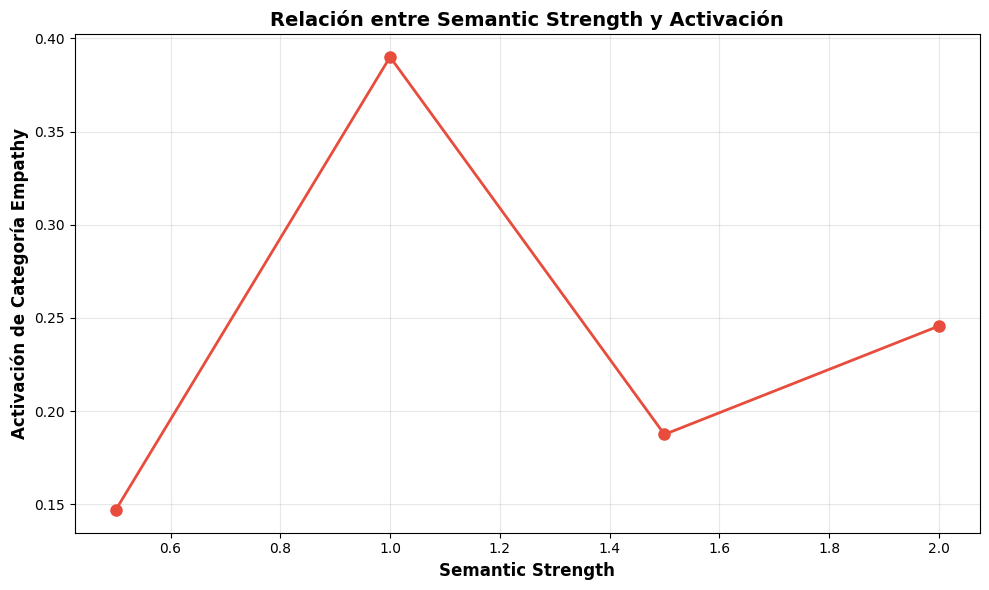

In [11]:
prompt = "I need help."
strengths = [0.5, 1.0, 1.5, 2.0]

print("EFECTO DE SEMANTIC_STRENGTH")
print("="*70)
print(f"Prompt: {prompt}\n")

activations = []

for strength in strengths:
    texts = model.generate_with_semantic_bias(
        prompt,
        HORMONE_PROFILES["empathic"],
        semantic_category="empathy",
        semantic_strength=strength,
        max_new_tokens=40
    )

    # Analizar activación
    analysis = analyze_semantic_activation(texts[0], manager)
    activations.append(analysis['similarities']['empathy'])

    print(f"\n[Strength = {strength}]")
    print(f"Activación empathy: {analysis['similarities']['empathy']:.3f}")
    print("-"*70)

# Visualizar relación
plt.figure(figsize=(10, 6))
plt.plot(strengths, activations, marker='o', linewidth=2, markersize=8, color='#e74c3c')
plt.xlabel('Semantic Strength', fontsize=12, fontweight='bold')
plt.ylabel('Activación de Categoría Empathy', fontsize=12, fontweight='bold')
plt.title('Relación entre Semantic Strength y Activación', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

##10. Análisis Cuantitativo (Múltiples Generaciones)

Ejecutando análisis cuantitativo...
(Esto puede tardar ~2 minutos)

   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...
   Pre-computing semantic bias for 'empathy'...

RESULTADOS AGREGADOS
          distinct_2         repetition_rate         sentiment        
                mean     std            mean     std      mean     std
condition                                                             
semantic      0.9411  0.1516          0.0452  0.1386    0.1668  0.1961
simple        0.9852  0.0345          0.0101  0.02

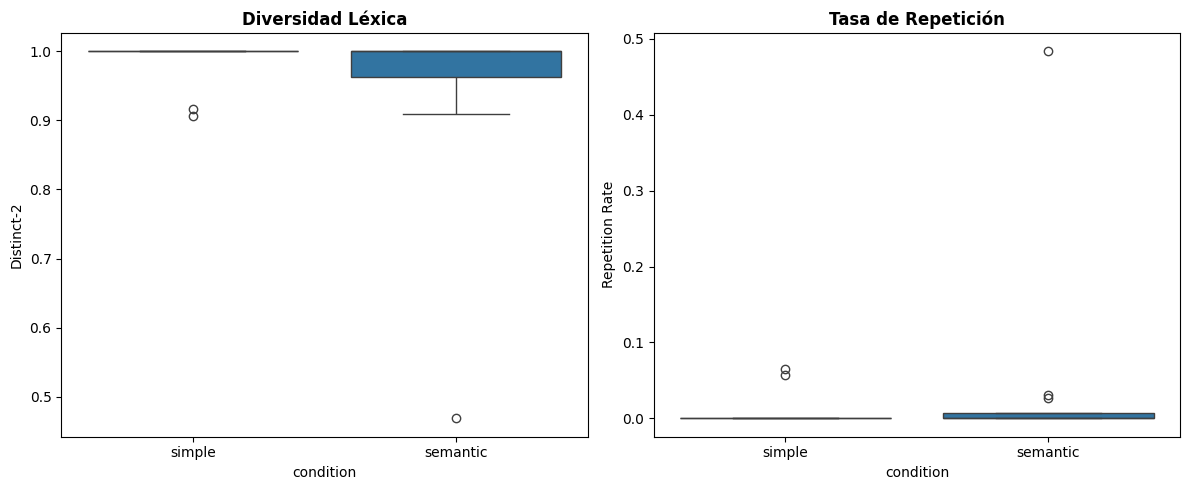

In [12]:
import pandas as pd
import numpy as np

prompts_test = [
    "I'm feeling anxious.",
    "Tell me a story.",
    "Explain quantum physics.",
    "I need support."
]

results = []

print("Ejecutando análisis cuantitativo...")
print("(Esto puede tardar ~2 minutos)\n")

for prompt in prompts_test:
    # Generar con sesgo simple
    for i in range(3):  # 3 repeticiones
        text = model.generate_with_hormones(
            prompt,
            HORMONE_PROFILES["empathic"],
            max_new_tokens=40
        )[0]

        metrics = TextMetrics.compute_all(text)

        results.append({
            'prompt': prompt,
            'condition': 'simple',
            'distinct_2': metrics['distinct_2'],
            'repetition_rate': metrics['repetition_rate'],
            'sentiment': metrics['sentiment_polarity']
        })

    # Generar con sesgo semántico
    for i in range(3):
        text = model.generate_with_semantic_bias(
            prompt,
            HORMONE_PROFILES["empathic"],
            semantic_category="empathy",
            semantic_strength=1.5,
            max_new_tokens=40
        )[0]

        metrics = TextMetrics.compute_all(text)

        results.append({
            'prompt': prompt,
            'condition': 'semantic',
            'distinct_2': metrics['distinct_2'],
            'repetition_rate': metrics['repetition_rate'],
            'sentiment': metrics['sentiment_polarity']
        })

df_results = pd.DataFrame(results)

# Comparación estadística
print("\nRESULTADOS AGREGADOS")
print("="*70)

summary = df_results.groupby('condition').agg({
    'distinct_2': ['mean', 'std'],
    'repetition_rate': ['mean', 'std'],
    'sentiment': ['mean', 'std']
}).round(4)

print(summary)

# Test estadístico
from scipy import stats

simple_d2 = df_results[df_results['condition'] == 'simple']['distinct_2']
semantic_d2 = df_results[df_results['condition'] == 'semantic']['distinct_2']

t_stat, p_value = stats.ttest_ind(simple_d2, semantic_d2)

print(f"\nT-test (Distinct-2):")
print(f"  t = {t_stat:.3f}, p = {p_value:.4f}")

if p_value < 0.05:
    print(f"Diferencia SIGNIFICATIVA")
else:
    print(f"Diferencia no significativa")

# Visualizar
import seaborn as sns

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(data=df_results, x='condition', y='distinct_2')
plt.title('Diversidad Léxica', fontweight='bold')
plt.ylabel('Distinct-2')

plt.subplot(1, 2, 2)
sns.boxplot(data=df_results, x='condition', y='repetition_rate')
plt.title('Tasa de Repetición', fontweight='bold')
plt.ylabel('Repetition Rate')

plt.tight_layout()
plt.show()

##11. Conclusión de lo hecho

- Usar sesgos semánticos basados en embeddings  
- Comparar sesgo simple vs semántico  
- Analizar activación semántica  
- Explorar categorías predefinidas  
- Crear categorías custom  
- Realizar análisis cuantitativo  


### Consideraciones

- Costo computacional moderado (embeddings en GPU)
- Requiere `sentence-transformers` instalado
- Mejor para tareas con objetivos semánticos claros

### Próximos Pasos

- **Notebook 04:** Sistema dinámico (hormonas que se adaptan)